In [32]:
import pandas as pd

def split_csv_by_column(input_file, column_name, output_folder):
    """
    Splits a CSV file into multiple CSVs based on unique values in a specified column.

    Parameters:
        input_file (str): Path to the input CSV file.
        column_name (str): Name of the column to split on.
        output_folder (str): Folder to save the output CSV files.
    """
    # Load the CSV file
    data = pd.read_csv(input_file)

    # Check if the column exists
    if column_name not in data.columns:
        raise ValueError(f"Column '{column_name}' not found in the CSV file.")

    # Get unique values in the specified column
    unique_values = data[column_name].unique()

    # Create and save a separate CSV for each unique value
    for value in unique_values:
        # Filter the data for the current value
        filtered_data = data[data[column_name] == value]

        # Generate the output file name
        output_file = f"{output_folder}/{value}.csv"

        # Save the filtered data to a CSV file
        filtered_data.to_csv(output_file, index=False)
        print(f"Saved file: {output_file}")

# Example usage
input_csv = "/content/Data.csv"
output_dir = "/content/Dataset"
column_to_split = "experiment_tag"  # Column to split on

# Ensure the output folder exists
import os
os.makedirs(output_dir, exist_ok=True)

# Split the CSV
split_csv_by_column(input_csv, column_to_split, output_dir)

Saved file: /content/Dataset/c1.csv
Saved file: /content/Dataset/c4.csv
Saved file: /content/Dataset/c6.csv


In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def import_data(file_path):
  # Load the dataset to examine its structure
  data = pd.read_csv(file_path)

  # Display the first few rows of the dataset to understand its structure
  data.head(), data.info()

  # Remove the original indexing and the dataset tag
  data_cleaned = data.drop(columns=['Unnamed: 0', 'dataset_tag', 'experiment_tag'])

  # Use the timestamp as the new indexing
  data_cleaned.set_index('timestamp', inplace=True)

  # Scale the numeric columns
  scaler = StandardScaler()
  numeric_columns = ['force_x', 'force_y', 'force_z', 'vibration_x', 'vibration_y', 'vibration_z', 'acoustic_emission_rms', 'tool_wear']
  data_cleaned[numeric_columns] = scaler.fit_transform(data_cleaned[numeric_columns])

  return data_cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34722 entries, 0 to 34721
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             34722 non-null  int64  
 1   force_x                34722 non-null  float64
 2   force_y                34722 non-null  float64
 3   force_z                34722 non-null  float64
 4   vibration_x            34722 non-null  float64
 5   vibration_y            34722 non-null  float64
 6   vibration_z            34722 non-null  float64
 7   acoustic_emission_rms  34722 non-null  float64
 8   timestamp              34722 non-null  float64
 9   tool_wear              34722 non-null  float64
 10  experiment_tag         34722 non-null  object 
 11  dataset_tag            34722 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34674 entries, 0 to 34673
Data columns (total 12 co

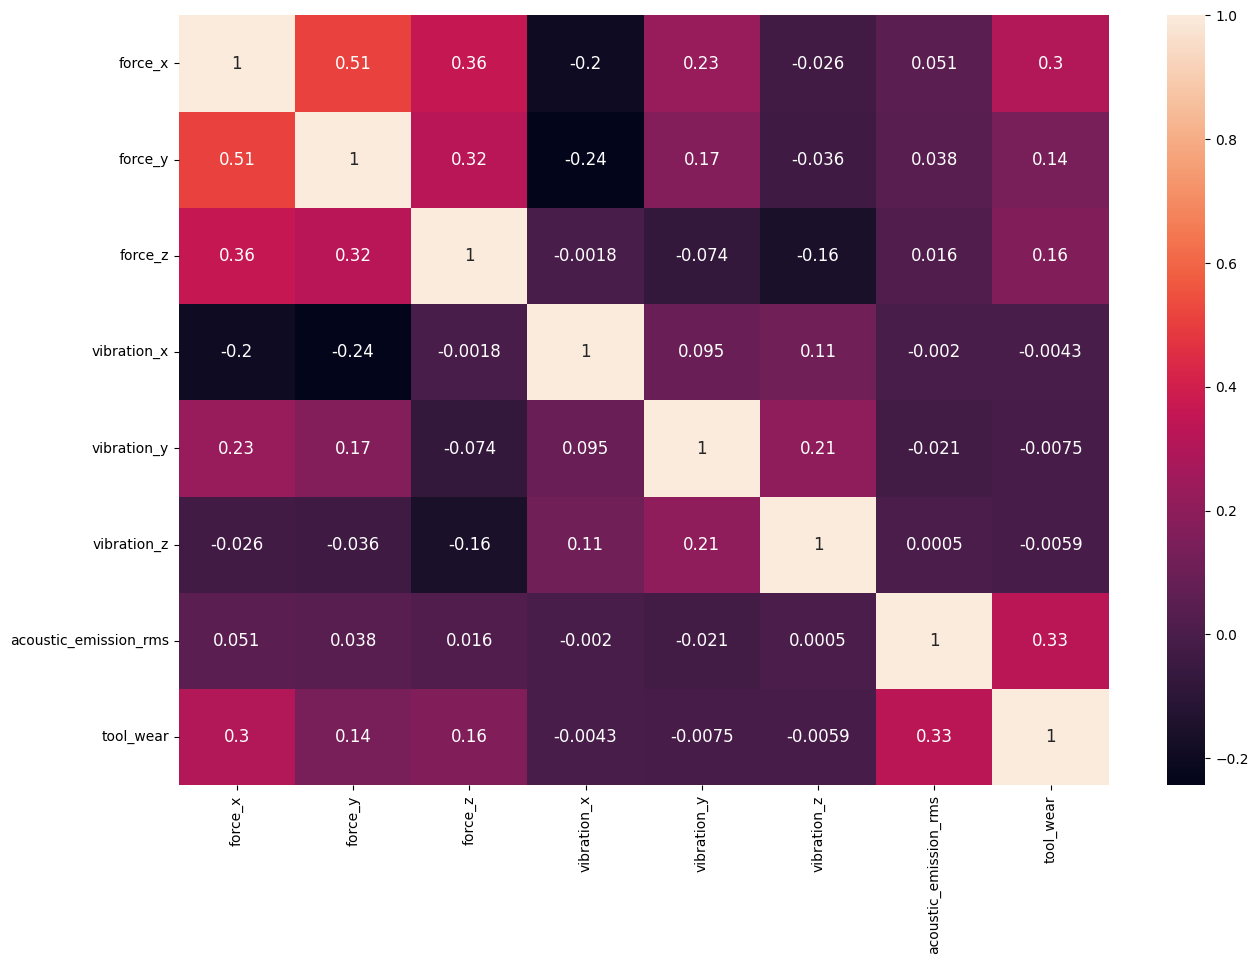

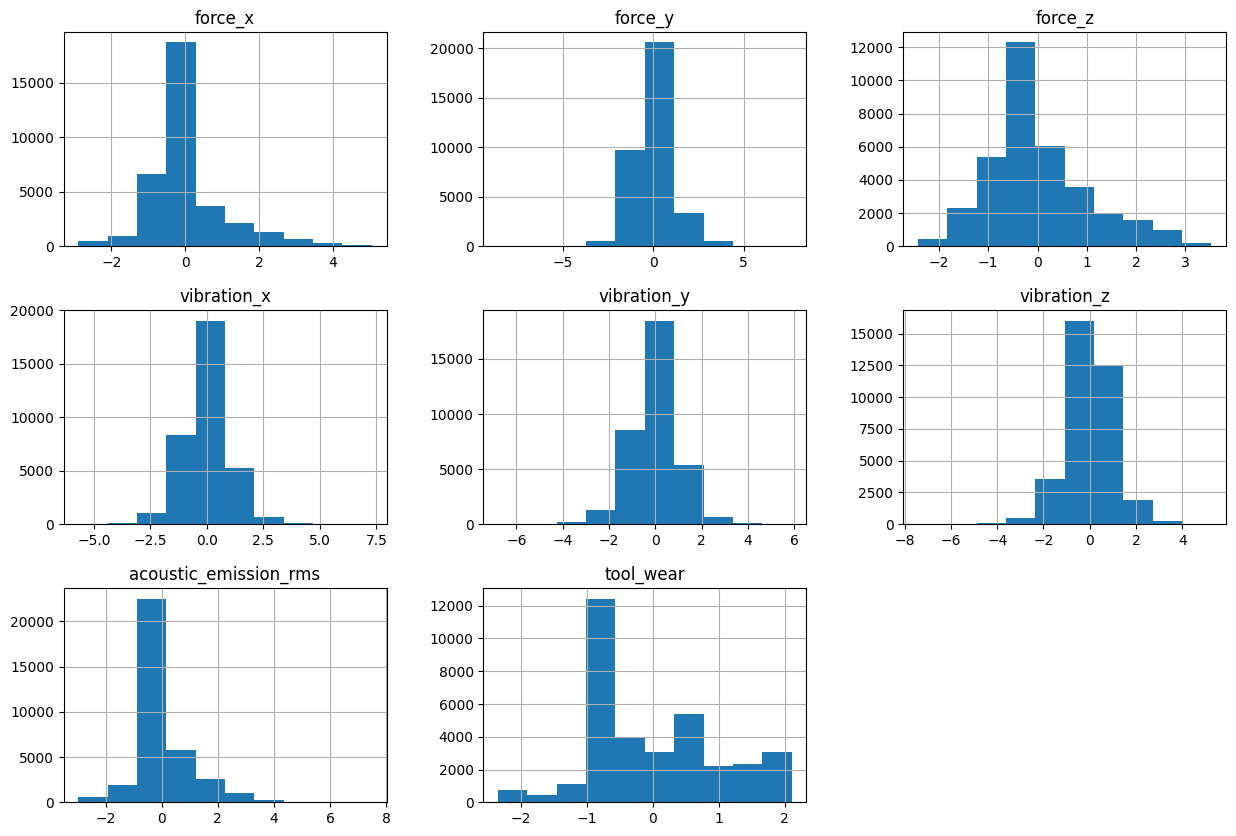

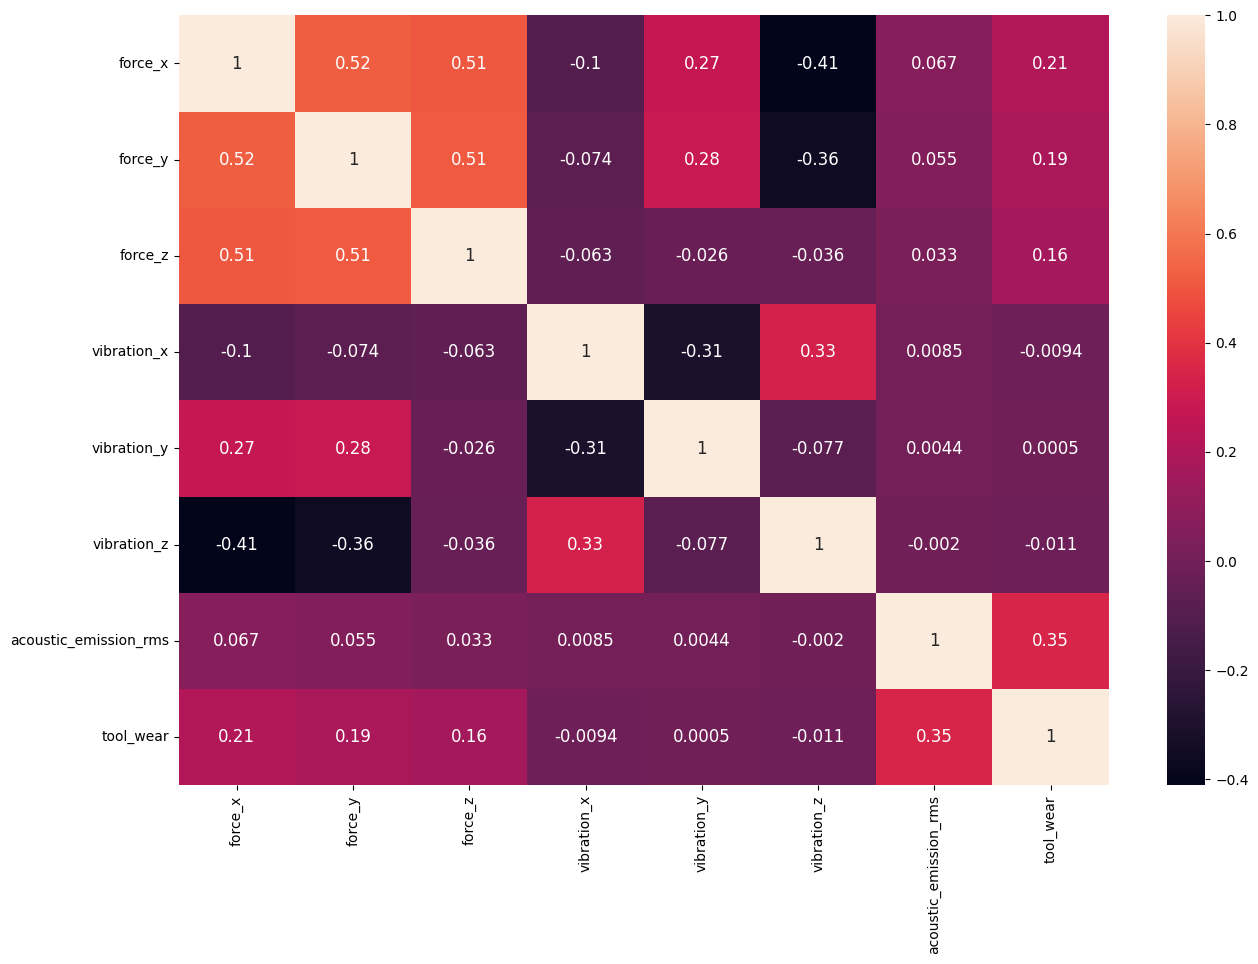

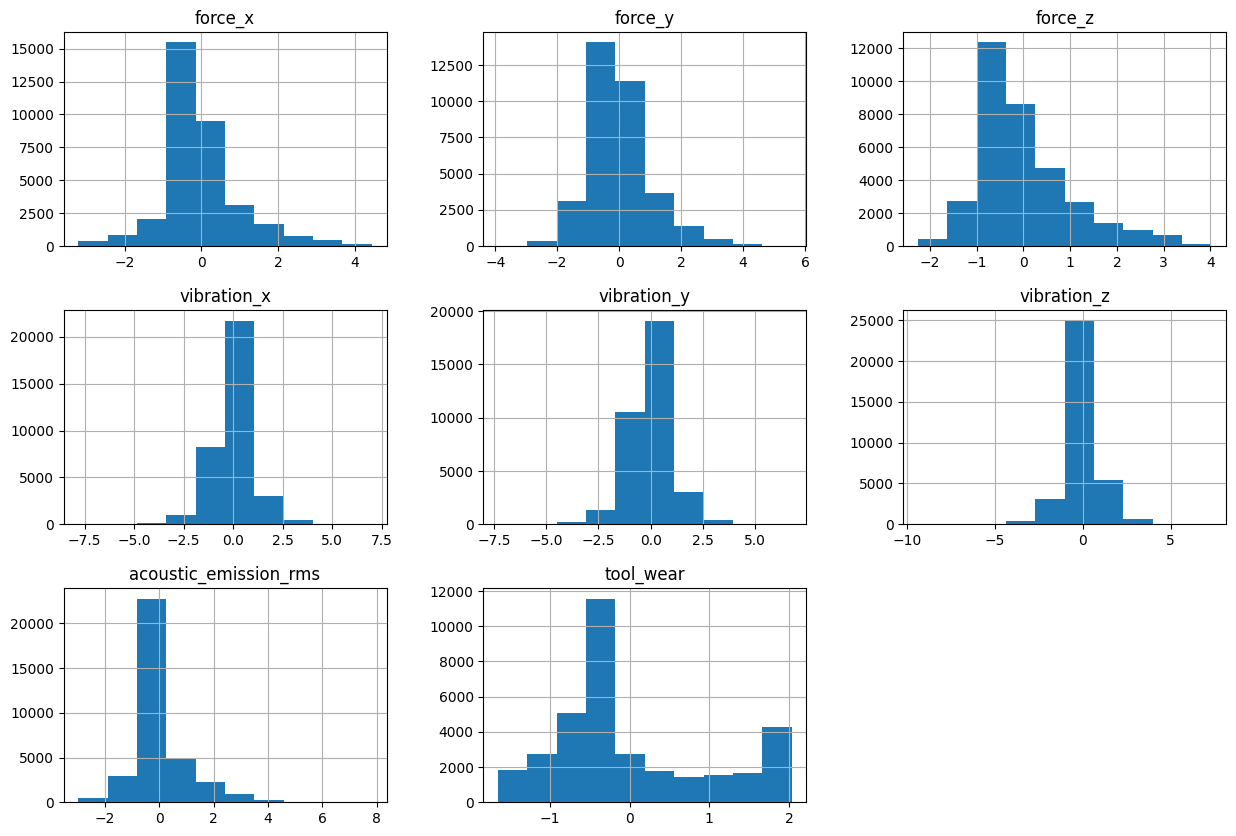

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def EDA(data_cleaned):
  plt.figure(figsize = (15,10))
  sns.heatmap(data_cleaned.corr(), annot = True, annot_kws = {"size":12})

  data_cleaned.hist(figsize=(15,10))

train_data = import_data("/content/Dataset/c1.csv")
test_data = import_data("/content/Dataset/c6.csv")

EDA(train_data)
EDA(test_data)

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to create sequences from the data
def create_sequences(features, target, time_steps=10):
    Xs, ys = [], []
    for i in range(len(features) - time_steps):
        Xs.append(features[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

# Assume train_data and test_data are your pandas DataFrames
# Extract features and target from the dataframes and convert to NumPy arrays
X_train_raw = train_data.drop(columns=['tool_wear']).values
y_train_raw = train_data['tool_wear'].values
X_test_raw = test_data.drop(columns=['tool_wear']).values
y_test_raw = test_data['tool_wear'].values

# Define the number of time steps you want in each sequence
time_steps = 10

# Create sequences for training and testing
X_train, y_train = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test, y_test = create_sequences(X_test_raw, y_test_raw, time_steps)

# Define the LSTM-based model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Regularisation to prevent overfitting
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,  # Do not shuffle time series data!
    verbose=1
)

# Make predictions on the test set
y_pred = model.predict(X_test)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


868/868 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5986 - mae: 0.3917 - val_loss: 0.6517 - val_mae: 0.7194
Epoch 2/100
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.5749 - mae: 0.3348 - val_loss: 0.9092 - val_mae: 0.8893
Epoch 3/100
868/868 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.5822 - mae: 0.3443 - val_loss: 0.5391 - val_mae: 0.6550
Epoch 4/100
868/868 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.5356 - mae: 0.3116 - val_loss: 0.6869 - val_mae: 0.7502
Epoch 5/100
868/868 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1694 - mae: 0.2047 - val_loss: 0.7019 - val_mae: 0.7574
Epoch 6/100
868/868 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.1112 - mae: 0.1667 - val_loss: 0.6260 - val_mae: 0.7098
Epoch 7/100
868/868 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0848 - mae: 0.1391 - val_loss: 0.6890 - val_mae: 0.7545
Epoch 8/100
868/868 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.1455 - mae: 0.1811 - val_loss: 0.6674 - val_mae: 0.7405
Epoch 9/100
868/868 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step

Training Loss (MSE): 0.3495, Training MAE: 0.4432
Testing Loss (MSE): 0.4770, Testing MAE: 0.5716
R^2 Score on Test Data: 0.5228


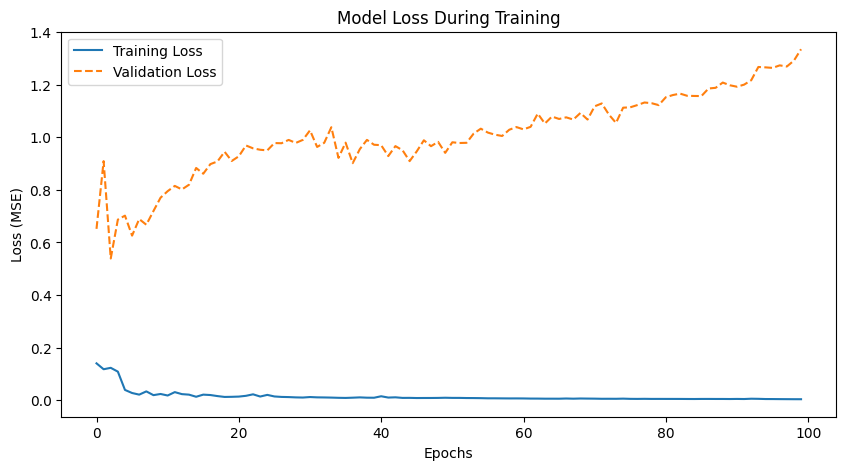

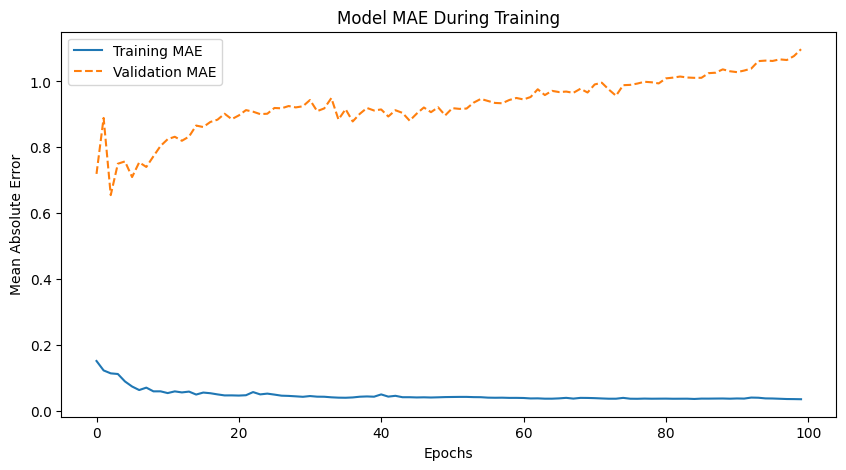

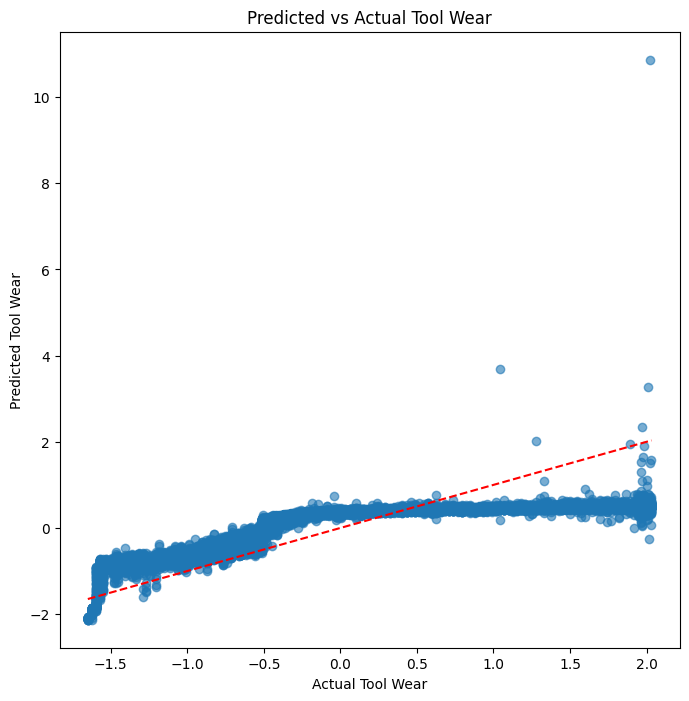

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 1. Evaluate the Model on Training and Testing Data
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")

# 2. Compute R^2 Score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score on Test Data: {r2:.4f}")

# 3. Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 4. Plot Training and Validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Model MAE During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# 5. Visualize Predictions vs Actual Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual Tool Wear')
plt.xlabel('Actual Tool Wear')
plt.ylabel('Predicted Tool Wear')
plt.show()


In [37]:
import joblib

# Save the model
joblib.dump(model, 'model.pkl')


['model.pkl']

In [39]:
# Flatten each sequence into a single row.
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert the NumPy array to a pandas DataFrame.
df = pd.DataFrame(X_test_flat)

# Save the DataFrame to a CSV file.
df.to_csv('test.csv', index=False)